# Assignment 3 Tunnelling in a Double Potential Well Redux

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation


import scipy.sparse.linalg as sp
from scipy.sparse import diags

In [2]:
# Defining Constants
ALPHA = 0.4
N_D = 600
EPSILON = (2 * np.pi) / 128
MASS = H_BAR = 1
X_MIN = np.sqrt(1 / ALPHA)
OMEGA = np.sqrt(8 * ALPHA * X_MIN ** 2)

# Problem A

In [3]:
x_array = np.linspace(-4, 4, N_D + 1)
delta_x = x_array[1] - x_array[0]

def potential(x: float, alpha: float) -> float:
    return alpha * x**4 - 2.0 * x**2 + 1.0 / alpha


potential_array = np.array([potential(x, ALPHA) for x in x_array])
potential_matrix = diags(potential_array, 0)
print(potential_matrix.shape)

kinetic_diag_array = np.full((N_D + 1), 1.0 / delta_x ** 2)
kinetic_off_array = np.full((N_D + 1) - 1, -0.5 / delta_x ** 2)
kinetic_matrix = diags([kinetic_diag_array, kinetic_off_array, kinetic_off_array], [0, 1, -1])
print(kinetic_matrix.shape)

hamiltonian_matrix = kinetic_matrix + potential_matrix

(601, 601)
(601, 601)


In [4]:
eigenvalues, eigenvectors = sp.eigsh(hamiltonian_matrix, k=2, which='SA')

index = np.argsort(eigenvalues)
eigenvalues = eigenvalues[index]
eigenvectors = eigenvectors[:, index]

phi_0_array = eigenvectors[:, 0]
norm_0_array = np.sqrt(np.sum(np.abs(phi_0_array) ** 2) * delta_x)
phi_norm_0_array = phi_0_array / norm_0_array  

phi_1_array = eigenvectors[:, 1]
norm_1_array = np.sqrt(np.sum(np.abs(phi_1_array) ** 2) * delta_x)
phi_norm_1_array = phi_1_array / norm_1_array

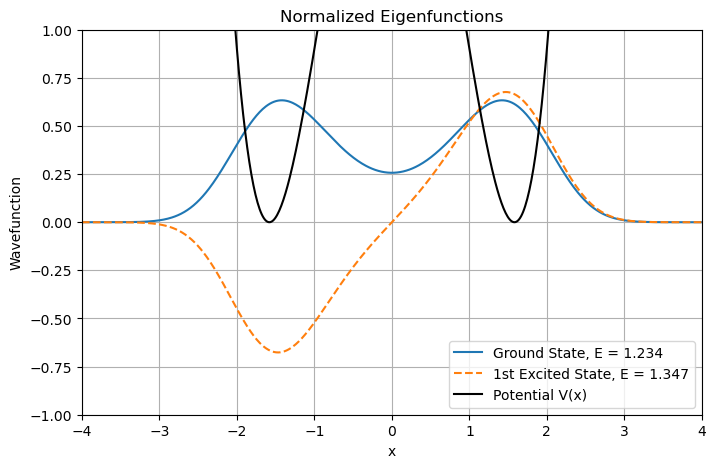

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(x_array, phi_norm_0_array, label=f'Ground State, E = {eigenvalues[0]:.3f}')
plt.plot(x_array, phi_norm_1_array, label=f'1st Excited State, E = {eigenvalues[1]:.3f}', linestyle='--')
plt.plot(x_array, potential_array, 'k-', label='Potential V(x)')

plt.xlim(-4, 4)
plt.ylim(-1, 1)
plt.xlabel('x')
plt.ylabel('Wavefunction')
plt.title('Normalized Eigenfunctions')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
delta_E = eigenvalues[1] - eigenvalues[0]
print(f'Ground State Energy: {eigenvalues[0]:.3f}')
print(f'1st Excited State Energy: {eigenvalues[1]:.3f}')
print(f'Energy Gap: {delta_E:.3f}')

tunneling_time = np.pi / delta_E

print(f'Tunneling Time: {tunneling_time:.3f}')

Ground State Energy: 1.234
1st Excited State Energy: 1.347
Energy Gap: 0.112
Tunneling Time: 27.943


### This is very similar to my answers from the previous assignment. In assignment 2, my tunnelling time was 29.452 seconds. This shows that both approaches are equivalent

# Problem B

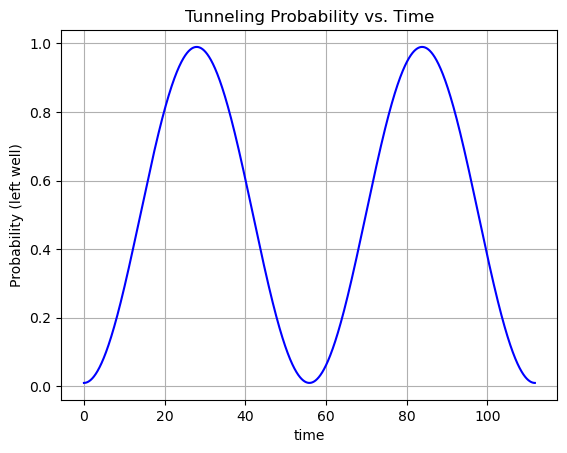

In [7]:
phi_0_array = (phi_norm_0_array + phi_norm_1_array) / np.sqrt(2)

def psi_t(t):
    phase_0 = np.exp(-1j * eigenvalues[0] * t)
    phase_1 = np.exp(-1j * eigenvalues[1] * t)
    return (1.0 / np.sqrt(2.0)) * (phase_0 * phi_norm_0_array + phase_1 * phi_norm_1_array)

total_time = tunneling_time * 4
time_array = np.linspace(0, total_time, 2000)

prob_left = []

left_indices = np.where(x_array < 0)[0]

for t in time_array:
    wave_function = psi_t(t)
    prob_density = np.abs(wave_function)**2
    prob_left.append(np.sum(prob_density[left_indices])*delta_x )

plt.figure()
plt.plot(time_array, prob_left, 'b-')
plt.xlabel('time')
plt.ylabel('Probability (left well)')
plt.title('Tunneling Probability vs. Time')
plt.grid(True)
plt.show()

# Problem C

### Path Integral Approach

In [8]:
def phi_p(x, X_MIN):
    prefactor = (OMEGA / np.pi)**(1/4)
    exponent = (-OMEGA/2) * (x - X_MIN)**2
    return prefactor * np.exp(exponent)

def phi_n(x, X_MIN):
    prefactor = (OMEGA / np.pi)**(1/4)
    exponent = (-OMEGA/2) * (x + X_MIN)**2
    return prefactor * np.exp(exponent)

def normalize_wave_function(psi: np.ndarray) -> np.ndarray:
    return psi / np.sqrt(np.sum(np.abs(psi)**2) * delta_x)

def phi_to_probability_density(phi: np.ndarray) -> np.ndarray:
    return np.abs(phi)**2

def advance_wave_function(psi: np.ndarray, k: np.ndarray, delta_x: float) -> np.ndarray:
    return np.dot(k, psi) * delta_x

def potential(x: float, alpha: float):
    return alpha * x**4 - 2.0 * x**2 + 1.0 / alpha

def elementary_propagator(xi, xj, alpha):
    prefactor = 1.0 / np.sqrt(2.0 * np.pi * 1j * EPSILON)
    exponent = 1j * (0.5 * ((xj - xi)**2) / EPSILON - potential(0.5*(xi + xj), alpha) * EPSILON)
    return prefactor * np.exp(exponent)

In [9]:
phi_path_init = (phi_norm_0_array + phi_norm_1_array) / np.sqrt(2)

k_eps = np.zeros((N_D + 1, N_D + 1), dtype=np.complex64)
for i in range(N_D + 1):
    for j in range(N_D + 1):
        k_eps[i, j] = elementary_propagator(x_array[i], x_array[j], ALPHA)


timesteps = int(np.ceil(total_time / EPSILON))
time_array_path = np.linspace(0, timesteps * EPSILON, timesteps + 1)


phi_path = phi_path_init.copy()
phi_path = normalize_wave_function(phi_path)

phi_list = [phi_path_init.copy()]

for i in range(timesteps):
    phi_path = advance_wave_function(phi_path, k_eps, delta_x)
    phi_path = normalize_wave_function(phi_path)
    phi_list.append(phi_path.copy())


In [10]:
psi_t_eig = psi_t
phi_list_path = phi_list

prob_list_path = []
for phi in phi_list_path:
    prob_list_path.append( np.abs(phi)**2 )

prob_list_eig = []
for t in time_array_path:
    wf_eig = psi_t_eig(t)
    prob_list_eig.append( np.abs(wf_eig)**2 )

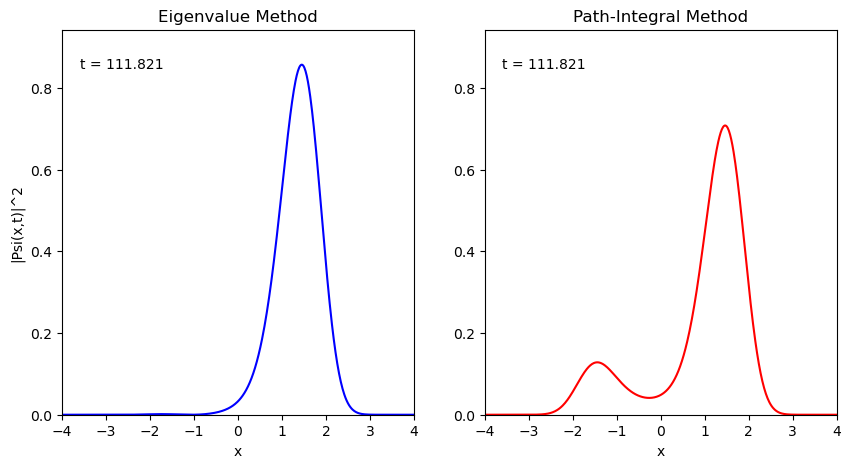

In [11]:
fig, (ax_eig, ax_path) = plt.subplots(1, 2, figsize=(10,5))

line_eig, = ax_eig.plot([], [], 'b-')
line_path, = ax_path.plot([], [], 'r-')

ax_eig.set_xlim(x_array[0], x_array[-1])
ax_eig.set_ylim(0, max(np.max(prob_list_eig), np.max(prob_list_path))*1.1)
ax_path.set_xlim(x_array[0], x_array[-1])
ax_path.set_ylim(0, max(np.max(prob_list_eig), np.max(prob_list_path))*1.1)

ax_eig.set_title("Eigenvalue Method")
ax_path.set_title("Path-Integral Method")

ax_eig.set_xlabel("x")
ax_path.set_xlabel("x")
ax_eig.set_ylabel("|Psi(x,t)|^2")

time_text_eig = ax_eig.text(0.05, 0.9, '', transform=ax_eig.transAxes)
time_text_path = ax_path.text(0.05, 0.9, '', transform=ax_path.transAxes)

def init():
    line_eig.set_data([], [])
    line_path.set_data([], [])
    time_text_eig.set_text('')
    time_text_path.set_text('')
    return line_eig, line_path, time_text_eig, time_text_path

def update(frame):
    xdata = x_array
    y_eig = prob_list_eig[frame]
    y_path = prob_list_path[frame]

    line_eig.set_data(xdata, y_eig)
    line_path.set_data(xdata, y_path)

    current_time = time_array_path[frame]
    time_text_eig.set_text(f"t = {current_time:.3f}")
    time_text_path.set_text(f"t = {current_time:.3f}")

    return line_eig, line_path, time_text_eig, time_text_path

ani = animation.FuncAnimation(
    fig,         
    update,       
    frames=len(prob_list_path), 
    init_func=init,
    blit=True,  
    interval=30
)
ani.save('double_well_evolution.gif', writer='pillow', fps=30)

plt.show()

### There seems to be no difference so I believe I did this correctly. There is some extra oscillation in the Path-Integral method likely caused by numerical instabilities, so I think maybe the Eigenvalue method is better

# MCMC and 2D Ising Model

In [22]:
def initialize_spins(N, init='random'):
    if init == 'random':
        spins = np.random.choice([1, -1], size=(N, N))
    elif init == 'up':
        spins = np.ones((N, N), dtype=int)
    return spins

def energy_change_if_flipped(spins, i, j, N, J=1):
    s = spins[i, j]
    s_up    = spins[(i-1) % N, j]
    s_down  = spins[(i+1) % N, j]
    s_left  = spins[i, (j-1) % N]
    s_right = spins[i, (j+1) % N]
    neighbor_sum = s_up + s_down + s_left + s_right
    
    dE = 2 * J * s * neighbor_sum
    return dE

def metropolis_sweep(spins, T):
    N = spins.shape[0]
    for _ in range(N*N):
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        
        dE = energy_change_if_flipped(spins, i, j, N, J=1)
        
        if dE <= 0:
            spins[i, j] *= -1
        else:
            if np.random.rand() < np.exp(-dE / T):
                spins[i, j] *= -1

def magnetization(spins):
    return np.mean(spins)

def run_ising_simulation(N=20, T=2.0, sweeps=20000, init='random', burn_in=5000, thin=1):
    spins = initialize_spins(N, init=init)
    mags = []
    
    for sweep in range(sweeps):
        metropolis_sweep(spins, T)
        m = magnetization(spins)
        mags.append(m)
    
    mags = mags[burn_in:]
    mags = mags[::thin]
    return np.array(mags)

# Part A

In [23]:
N = 20
sweeps = 20000
burn_in = 5000

T = 2.0

mags_T = run_ising_simulation(N=N, T=T, sweeps=sweeps, init='random', burn_in=burn_in)

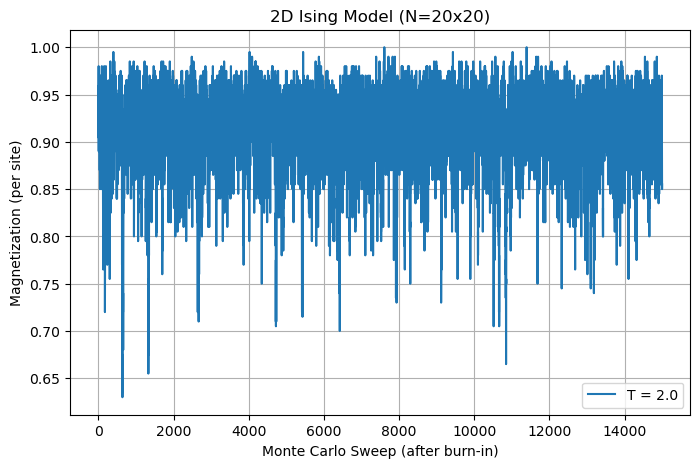

In [24]:
plt.figure(figsize=(8,5))
plt.plot(mags_T, label=f"T = {T}")
plt.xlabel("Monte Carlo Sweep (after burn-in)")
plt.ylabel("Magnetization (per site)")
plt.title("2D Ising Model (N=20x20)")
plt.grid(True)
plt.legend()
plt.show()

### It may take a few thousand sweeps to forget the fully magnetized initial condition and reach equilibrium. Maybe 1000-5000 sweeps could be a good number of burn in sweeps

### After discarding the burn in region, you want enough additional sweeps to get good statistics. For a 20x20 system 20-50 thousand sweeps may be good. 

# Part B

T=1.0,  <M>=0.999,  std(M)=0.002
T=1.2,  <M>=-0.997,  std(M)=0.004
T=1.4,  <M>=0.991,  std(M)=0.008
T=1.6,  <M>=0.979,  std(M)=0.014
T=1.8,  <M>=-0.957,  std(M)=0.022
T=2.0,  <M>=0.911,  std(M)=0.044
T=2.2,  <M>=-0.801,  std(M)=0.102
T=2.4,  <M>=-0.012,  std(M)=0.514
T=2.6,  <M>=0.020,  std(M)=0.290
T=2.8,  <M>=-0.004,  std(M)=0.217
T=3.0,  <M>=-0.006,  std(M)=0.168
T=3.2,  <M>=-0.001,  std(M)=0.143
T=3.4,  <M>=-0.003,  std(M)=0.128
T=3.6,  <M>=0.005,  std(M)=0.119
T=3.8,  <M>=-0.000,  std(M)=0.108
T=4.0,  <M>=-0.001,  std(M)=0.104


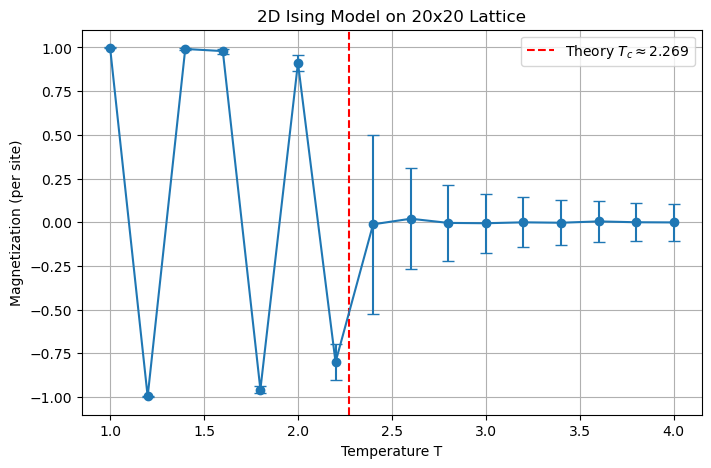

In [25]:
N = 20
sweeps = 20000 
burn_in = 5000   
thin = 1         
T_values = np.arange(1.0, 4.1, 0.2)

mean_mags = []
std_mags = []

for T in T_values:
    mags = run_ising_simulation(
        N=N, 
        T=T, 
        sweeps=sweeps,
        burn_in=burn_in, 
        init='random', 
        thin=thin
    )
    m_mean = np.mean(mags)
    m_std  = np.std(mags, ddof=1) 
    mean_mags.append(m_mean)
    std_mags.append(m_std)
    
    print(f"T={T:.1f},  <M>={m_mean:.3f},  std(M)={m_std:.3f}")

mean_mags = np.array(mean_mags)
std_mags  = np.array(std_mags)

In [ ]:

plt.figure(figsize=(8,5))
plt.errorbar(T_values, mean_mags, yerr=std_mags, fmt='o-', capsize=4)
plt.axvline(x=2.269, color='r', linestyle='--', label='Theory $T_c \\approx 2.269$')
plt.xlabel("Temperature T")
plt.ylabel("Magnetization (per site)")
plt.title(f"2D Ising Model on {N}x{N} Lattice")
plt.grid(True)
plt.legend()
plt.show()

### I did observe a sharp transition however if I did not:
- Real ising model transitions are sharp only in the infinite limit
- Steps of 0.2 might skip over the critical point
- May need more sweeps
- Magnetization data could be biased by the initial conditions